# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

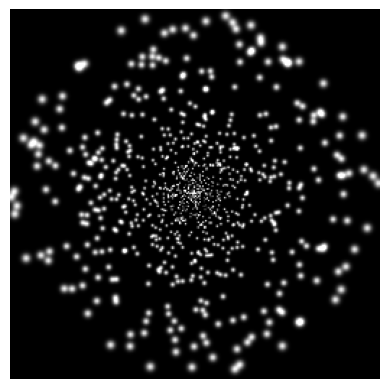

In [3]:
# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [4]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

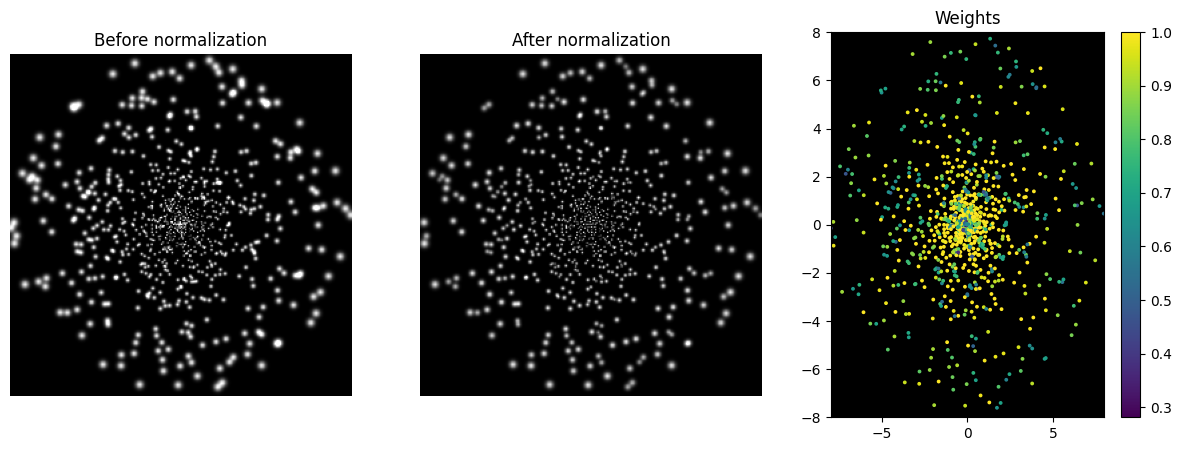

In [5]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=1,
    scale=0.5,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.05,
    steps=50,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init)
stim_weights = normalizer.weights

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# Phosphene Density Maps

In [6]:
from phosphene.density import VisualFieldMapper

In [7]:
mapper = VisualFieldMapper(simulator=simulator)

In [8]:
# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=32, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

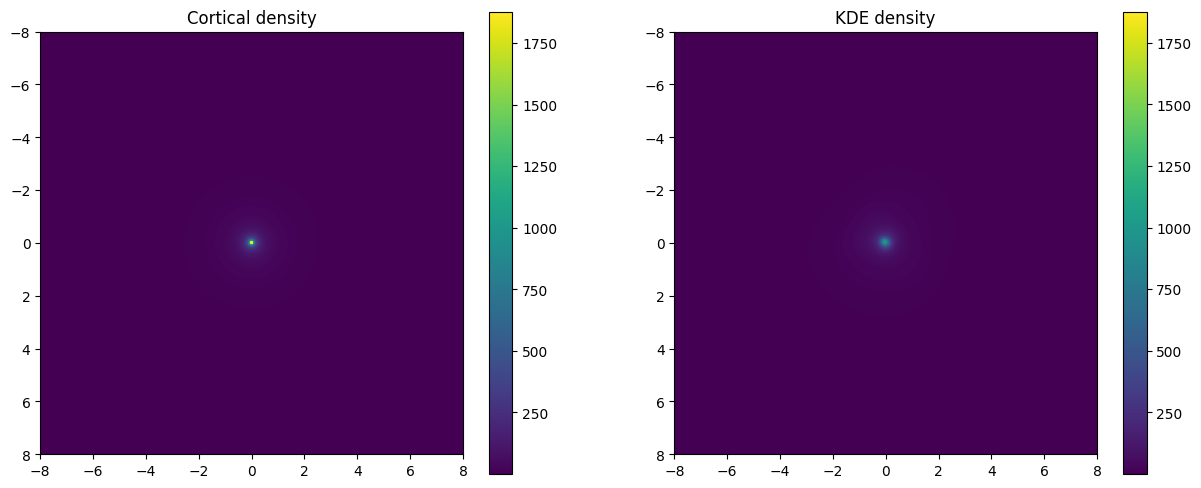

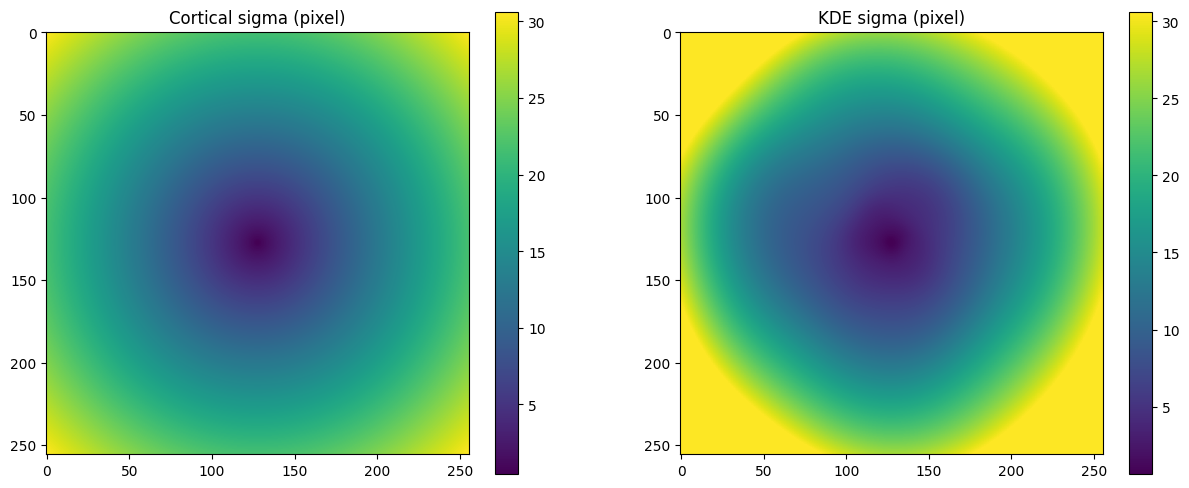

In [9]:
# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(density_cortical, cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2])
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(density_kde, cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=density_cortical.max())
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Input Modulation

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_loader = DataLoader(
    ImageFolder('../../data/LaPa_zoomed/', transform=transform),
    batch_size=1,
    shuffle=False
)

In [11]:
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation

In [12]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=119,
    kernel_type="log",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

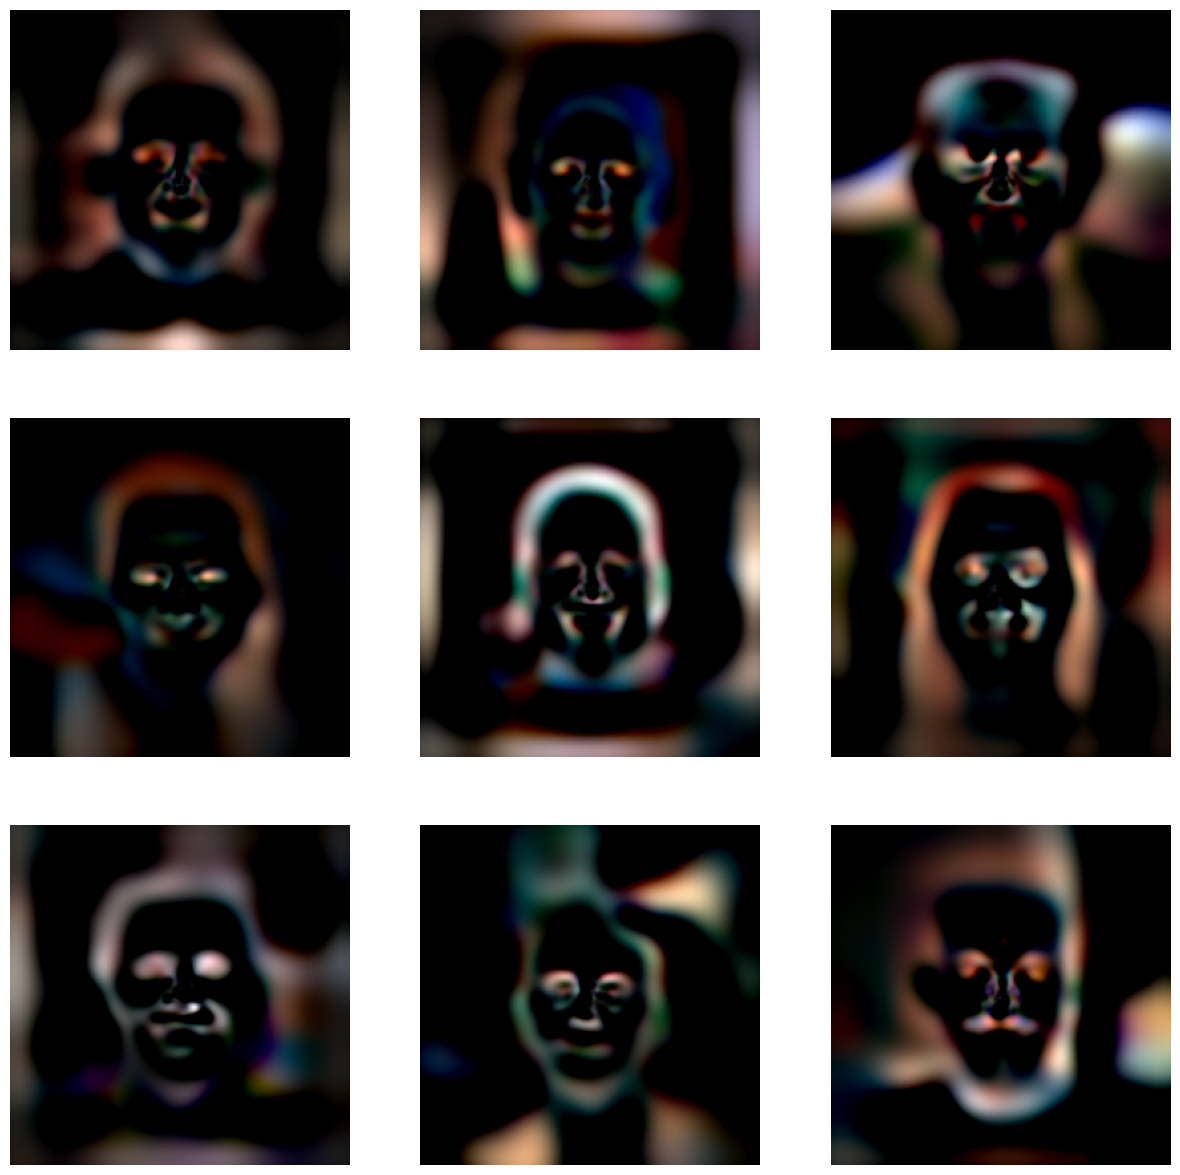

In [13]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda().detach()

    with torch.no_grad():
        filtered_img = layer(img).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    plt.axis('off')

plt.show()

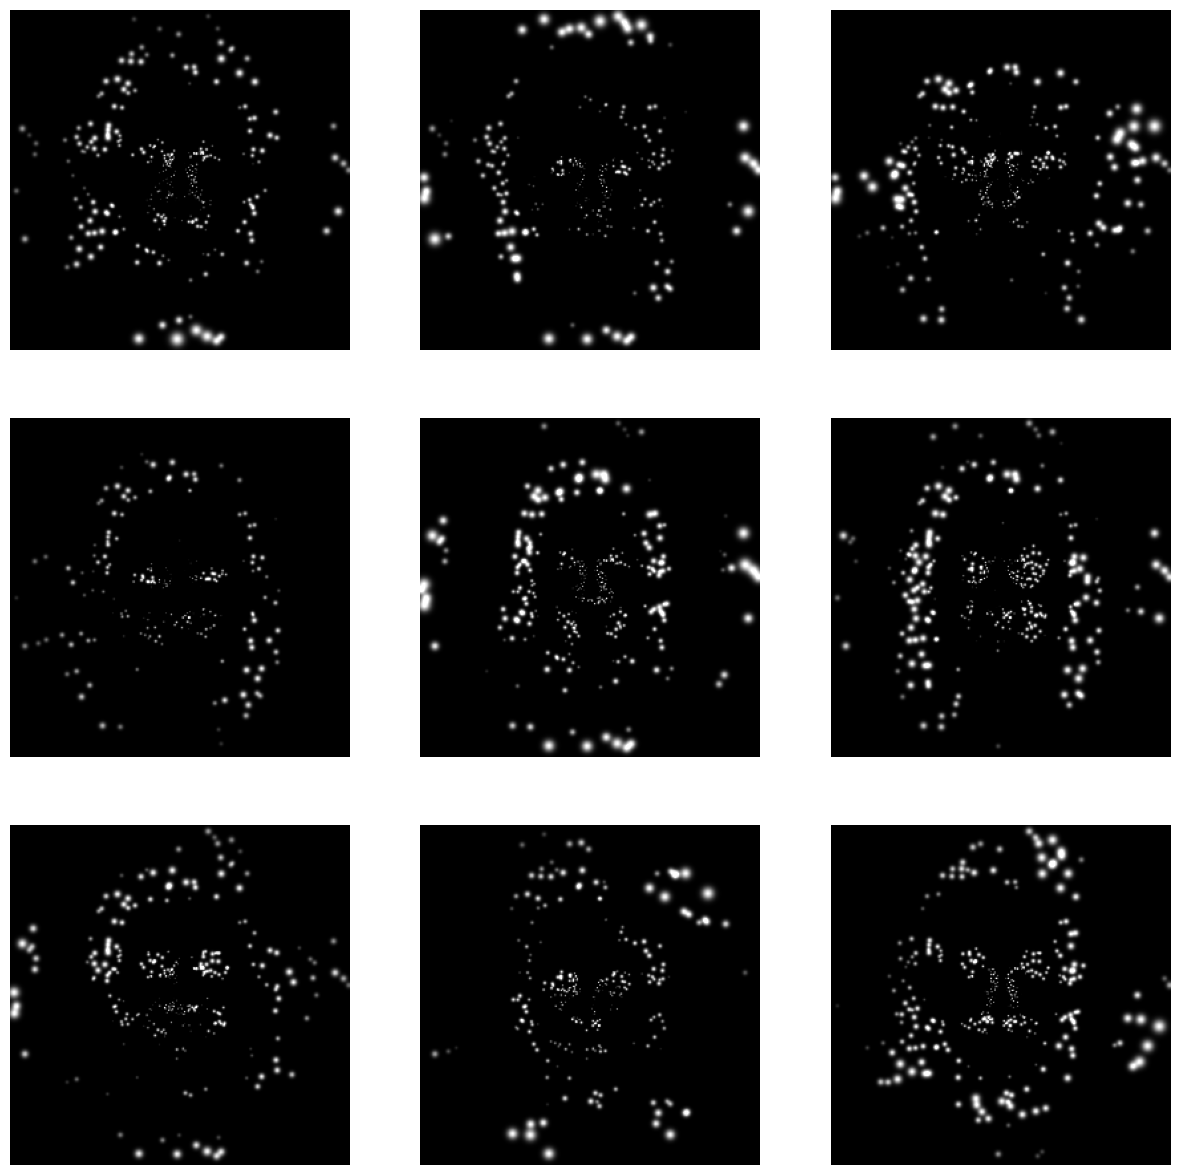

In [14]:
# show the images through the phosphene simulator

phos_images = []
for img in filtered_images:
    simulator.reset()
    stim = simulator.sample_stimulus(img[0].max(0), rescale=True) * stim_weights * np.pi
    phos_img = simulator(stim)
    phos_images.append(phos_img)

# show phos_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(phos_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.cpu(), cmap='gray')
    plt.axis('off')

plt.show()

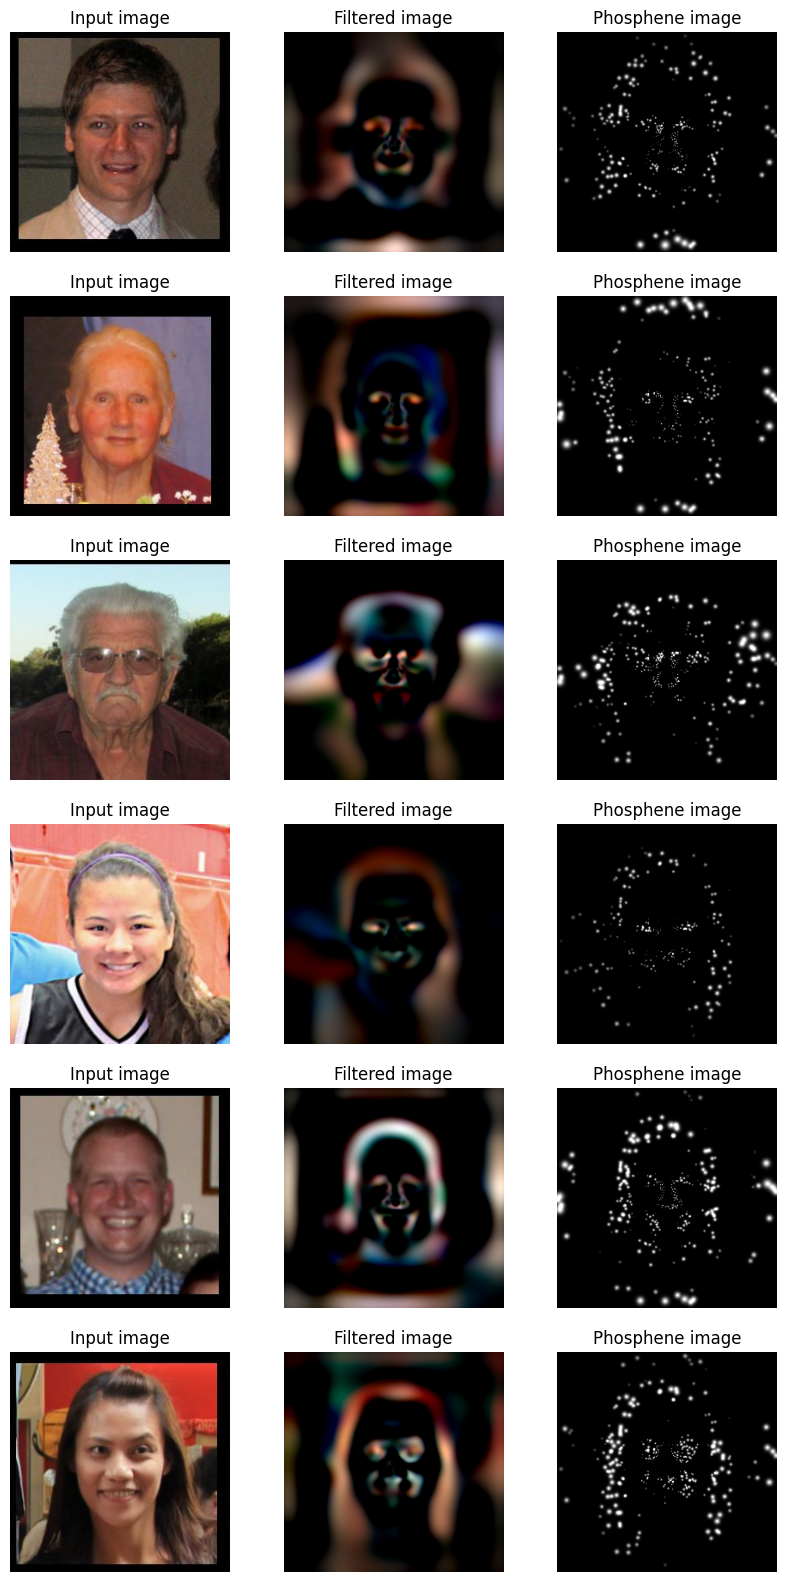

In [15]:
# show side by side:
# input image, filtered image and phosphene image

plt.figure(figsize=(10, 20))
imgs_to_show = 6

for i, (img, filtered_img, phos_img) in enumerate(zip(images, filtered_images, phos_images)):

    plt.subplot(imgs_to_show, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Input image')

    plt.subplot(imgs_to_show, 3, 3*i+2)
    plt.imshow(filtered_img[0].transpose(1, 2, 0))
    plt.axis('off')
    plt.title('Filtered image')

    plt.subplot(imgs_to_show, 3, 3*i+3)
    plt.imshow(phos_img.cpu(), cmap='gray')
    plt.axis('off')
    plt.title('Phosphene image')

    if i == imgs_to_show - 1:
        break

## Gaussian Modulation

In [16]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

data_loader = DataLoader(
    ImageFolder('../../data/LaPa_zoomed/', transform=transform),
    batch_size=1,
    shuffle=True
)

In [17]:
from spatial_frequency.components.modulated_conv2d import UnifiedInputModulation

In [18]:
sigma_map_tensor = torch.tensor(sigma_cortical_pix).float().cuda().detach()

layer = UnifiedInputModulation(
    kernel_size=99,
    kernel_type="gaussian",
    sigma_map=sigma_map_tensor,
    dilation=1,
    padding_mode='reflect'
).cuda()
layer.eval()

UnifiedInputModulation()

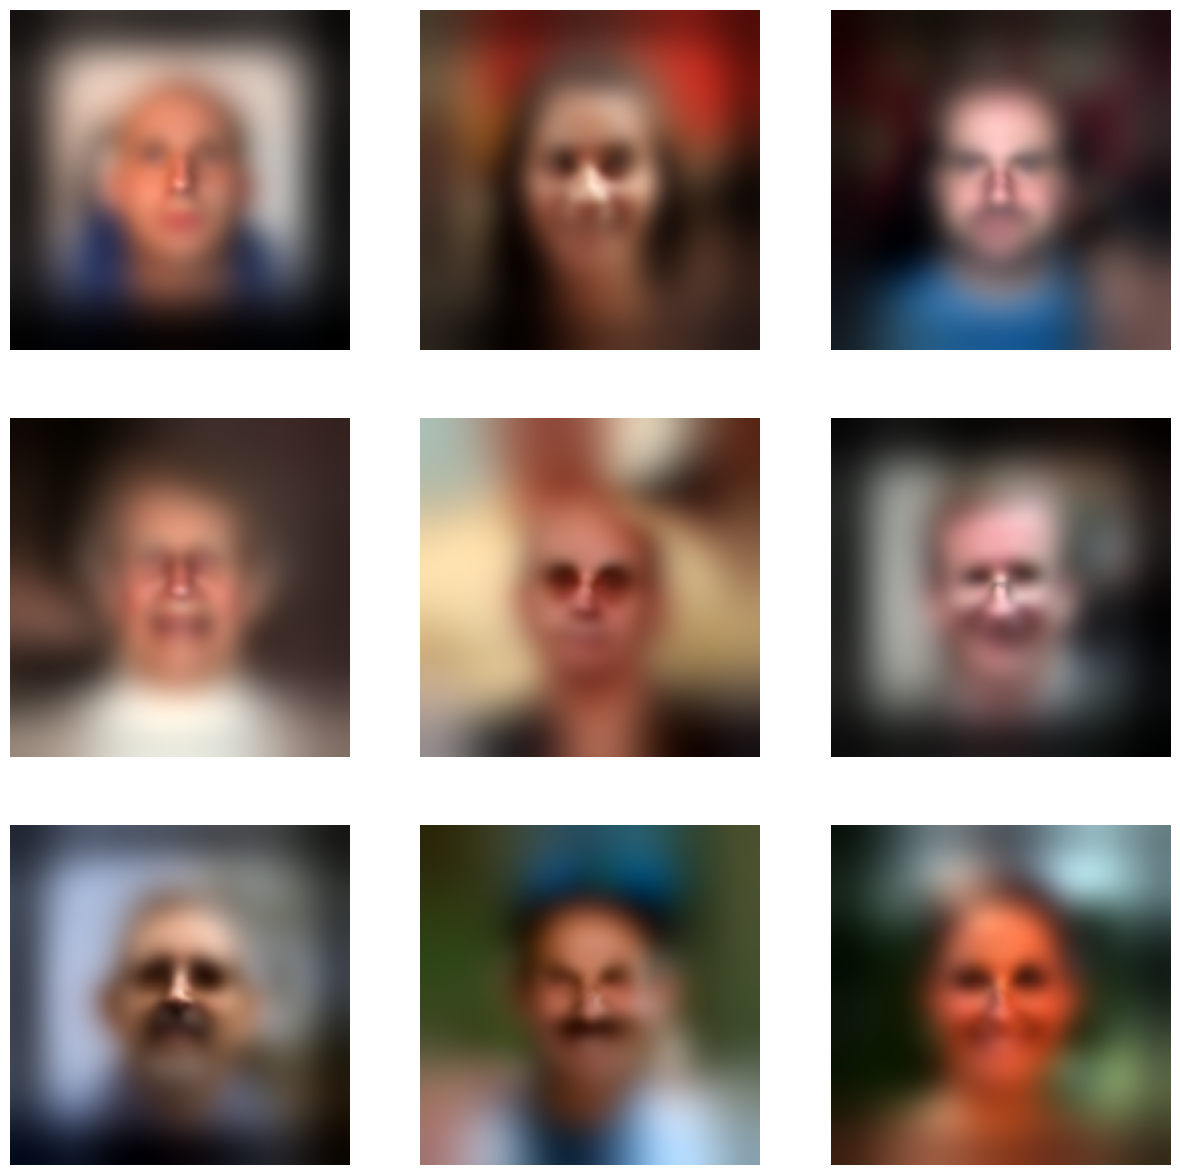

In [19]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda().detach()

    with torch.no_grad():
        filtered_img = layer(img).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    plt.axis('off')

plt.show()